In [ ]:
pip install lib-pybroker

# Get Data

In [ ]:
from pybroker import YFinance

yfinance = YFinance()
df = yfinance.query(['GOOG', 'MSFT'], start_date='1/1/2022', end_date='1/1/2023')
df.head()

Loading bar data...
[*********************100%***********************]  2 of 2 completed
Loaded bar data: 0:00:00 



,date,symbol,open,high,low,close,volume,adj_close
0,2022-01-03,GOOG,144.475494,145.550003,143.502502,145.074493,25214000,145.074493
1,2022-01-03,MSFT,335.350006,338.000000,329.779999,334.750000,28865100,330.813873
2,2022-01-04,GOOG,145.550507,146.610001,143.816147,144.416504,22928000,144.416504
3,2022-01-04,MSFT,334.829987,335.200012,326.119995,329.010010,32674300,325.141388
4,2022-01-05,GOOG,144.181000,144.298004,137.523499,137.653503,49642000,137.653503


In [ ]:
from pybroker import Alpaca
import os

alpaca = Alpaca(os.environ['ALPACA_API_KEY'], os.environ['ALPACA_API_SECRET'])

df = alpaca.query(
    ['GOOG', 'MSFT'],
    start_date='1/1/2022',
    end_date='1/1/2023',
    timeframe='1m'
)

df

# Caching

In [ ]:
import pybroker

pybroker.enable_data_source_cache('yfinance')

# Custom Data Source

In [ ]:
import pandas as pd
import pybroker
from pybroker.data import DataSource

class CSVDataSource(DataSource):

    def __init__(self):
        super().__init__()
        # Register custom columns in the CSV.
        pybroker.register_columns('rsi')

    def _fetch_data(self, symbols, start_date, end_date, _timeframe):
        df = pd.read_csv('data/prices.csv')
        df = df[df['symbol'].isin(symbols)]
        df['date'] = pd.to_datetime(df['date'])
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Pairs Trading

In [ ]:
from pybroker import Strategy, StrategyConfig

In [ ]:
def box_trade(ctx):
  # Obtain data on dbx (it will match the same date)
  dbx = ctx.foreign(symbol="DBX", col="close")

  # Wait to have enough data
  if ctx.bars <5:
    return

  # Calculate the 5 day percentage move differences
  box_5d_pct_move = ((ctx.close[-1] - ctx.close[-5]) / ctx.close[-5]) * 100
  dbx_5d_pct_move = ((dbx[-1] - dbx[-5]) / dbx[-5]) * 100

  move_diff = box_5d_pct_move - dbx_5d_pct_move

  # Trading logic
  if move_diff >= 5 and not ctx.long_pos():
    # The line below deploys all of our available funds (for less do 0.5, etc.)
    ctx.buy_shares = ctx.calc_target_shares(1)

  if move_diff <= 5 and not ctx.short_pos():
    ctx.sell_shares = ctx.calc_target_shares(1)

In [ ]:
config = StrategyConfig(initial_cash=100_000)
strategy = Strategy(YFinance(), '3/1/2018', '3/1/2023', config)
strategy.add_execution(box_trade, ['BOX', 'DBX'])
result = strategy.backtest(calc_bootstrap=False)

Backtesting: 2018-03-01 00:00:00 to 2023-03-01 00:00:00

Loaded cached bar data.

Test split: 2018-03-01 00:00:00 to 2023-02-28 00:00:00


100% (1258 of 1258) |####################| Elapsed Time: 0:00:02 Time:  0:00:02



Finished backtest: 0:00:02


In [ ]:
result.portfolio.tail()

,cash,equity,margin,market_value,pnl,fees
date,,,,,,
2023-02-22,24.03,204070.95,67904.00,233286.95,133286.95,0.0
2023-02-23,24.03,204192.19,67264.00,234048.19,134048.19,0.0
2023-02-24,24.03,201524.92,65920.00,232724.92,132724.92,0.0
2023-02-27,203040.41,203040.41,65568.00,234592.41,134592.41,0.0
2023-02-28,406501.37,406501.37,268314.79,438767.54,338767.54,0.0


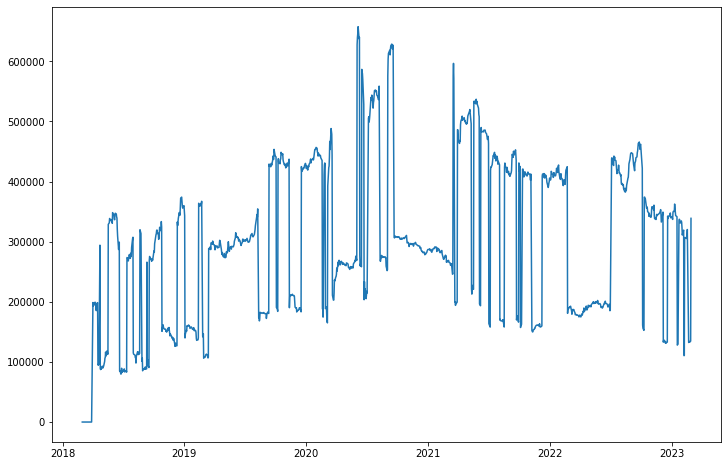

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(result.portfolio.index, result.portfolio['pnl'])

In [ ]:
result.metrics_df

,name,value
0,trade_count,133.000000
1,initial_market_value,100000.000000
2,end_market_value,438767.540000
3,total_pnl,5920.410000
4,unrealized_pnl,332847.130000
5,total_return_pct,5.920410
6,total_profit,573194.180000
7,total_loss,-567273.770000
8,total_fees,0.000000
9,max_drawdown,-547151.350000


In [ ]:
result.trades.tail()

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar
id,,,,,,,,,,,,
129,long,BOX,2023-01-18,2023-01-20,31.05,30.80,6672,-1668.00,-0.81,8401.27,2,-834.00
130,short,BOX,2023-01-23,2023-02-07,31.38,34.08,6631,-17903.70,-7.92,-9502.43,11,-1627.61
131,long,BOX,2023-02-07,2023-02-08,34.08,34.44,5505,1981.80,1.06,-7520.63,1,1981.80
132,short,BOX,2023-02-09,2023-02-21,34.51,32.82,5550,9379.50,5.15,1858.87,7,1339.93
133,long,BOX,2023-02-21,2023-02-27,32.82,33.49,6062,4061.54,2.04,5920.41,4,1015.39


In [ ]:
result.positions.tail()

long_shares  short_shares  close     equity  market_value  \
symbol date                                                                    
BOX    2023-02-24         6062             0  33.24  201500.89     201500.89   
DBX    2023-02-24            0          3200  20.60       0.00      31200.00   
       2023-02-27            0          3200  20.49       0.00      31552.00   
BOX    2023-02-28            0          6088  33.35       0.00        426.17   
DBX    2023-02-28            0          3200  20.40       0.00      31840.00   

                      margin  unrealized_pnl  
symbol date                                   
BOX    2023-02-24       0.00         2546.05  
DBX    2023-02-24   65920.00        31200.00  
       2023-02-27   65568.00        31552.00  
BOX    2023-02-28  203034.79          426.17  
DBX    2023-02-28   65280.00        31840.00

# Bootstrap

In [ ]:
result = strategy.backtest(calc_bootstrap=True)
result.metrics_df

Backtesting: 2018-03-01 00:00:00 to 2023-03-01 00:00:00

Loaded cached bar data.

Test split: 2018-03-01 00:00:00 to 2023-02-28 00:00:00


100% (1258 of 1258) |####################| Elapsed Time: 0:00:01 Time:  0:00:01



Calculating bootstrap metrics: sample_size=1000, samples=10000...
Calculated bootstrap metrics: 0:00:08 

Finished backtest: 0:00:10


,name,value
0,trade_count,133.000000
1,initial_market_value,100000.000000
2,end_market_value,438767.540000
3,total_pnl,5920.410000
4,unrealized_pnl,332847.130000
5,total_return_pct,5.920410
6,total_profit,573194.180000
7,total_loss,-567273.770000
8,total_fees,0.000000
9,max_drawdown,-547151.350000


In [ ]:
result.bootstrap.conf_intervals

lower     upper
name              conf                     
Log Profit Factor 97.5% -0.362708  0.487121
                  95%   -0.294159  0.424757
                  90%   -0.205792  0.346576
Sharpe Ratio      97.5% -0.053769  0.070229
                  95%   -0.043599  0.060231
                  90%   -0.032519  0.048648

In [ ]:
result.bootstrap.drawdown_conf

,amount,percent
conf,,
99.9%,-5907435.35,-99.999972
99%,-4685254.07,-99.999379
95%,-3697911.48,-99.992593
90%,-3214869.95,-99.973827


# Walk-forward

In [ ]:
result = strategy.walkforward(windows=3, train_size=0.5, lookahead=1)

Backtesting: 2018-03-01 00:00:00 to 2023-03-01 00:00:00

Loaded cached bar data.

Test split: 2019-06-04 00:00:00 to 2020-08-28 00:00:00


100% (314 of 314) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Test split: 2020-08-31 00:00:00 to 2021-11-26 00:00:00


100% (314 of 314) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Test split: 2021-11-29 00:00:00 to 2023-02-28 00:00:00


100% (314 of 314) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Setting number of bootstraps to 1.


Calculating bootstrap metrics: sample_size=1000, samples=10000...
Calculated bootstrap metrics: 0:00:00 

Finished backtest: 0:00:01


In [ ]:
result.metrics_df

,name,value
0,trade_count,94.000000
1,initial_market_value,100000.000000
2,end_market_value,351745.870000
3,total_pnl,-29543.370000
4,unrealized_pnl,281289.240000
5,total_return_pct,-29.543370
6,total_profit,334389.280000
7,total_loss,-363932.650000
8,total_fees,0.000000
9,max_drawdown,-536271.560000


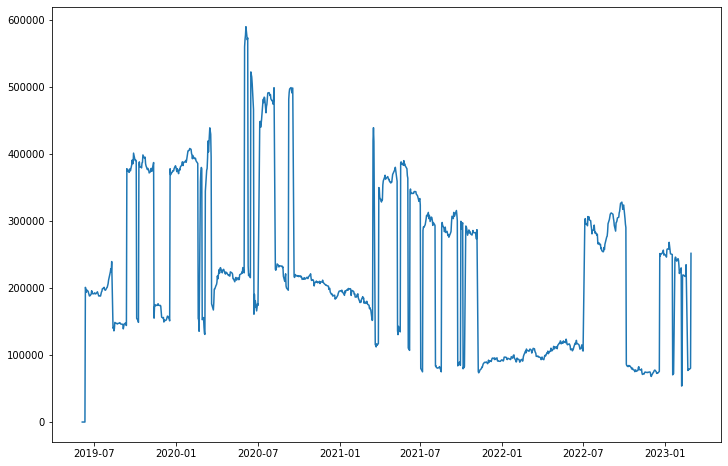

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(result.portfolio.index, result.portfolio['pnl'])

# Indicators

In [ ]:
import numpy as np
from numba import njit

In [ ]:
def cmma(bar_data, lookback):

    @njit  # Enable Numba JIT.
    def vec_cmma(values):
        # Initialize the result array.
        n = len(values)
        out = np.array([np.nan for _ in range(n)])

        # For all bars starting at lookback:
        for i in range(lookback, n):
            # Calculate the moving average for the lookback.
            ma = 0
            for j in range(i - lookback, i):
                ma += values[j]
            ma /= lookback
            # Subtract the moving average from value.
            out[i] = values[i] - ma
        return out

    # Calculate with close prices.
    return vec_cmma(bar_data.close)